In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

logging.getLogger().setLevel(logging.INFO)

In [3]:
def get_cifar10():
    def create_superclass(x):
        return 0 if x in [0, 1, 8, 9] else 1
    v_create_superclass = np.vectorize(create_superclass)
    
    (x_train, y_sub_train), (x_test, y_sub_test) = keras.datasets.cifar10.load_data()
    x_train, x_test = x_train / 255, x_test / 255
    y_super_train, y_super_test = to_categorical(v_create_superclass(y_sub_train)), to_categorical(v_create_superclass(y_sub_test))
    y_sub_train, y_sub_test = to_categorical(y_sub_train), to_categorical(y_sub_test)
    
    return (x_train, y_super_train, y_sub_train), (x_test, y_super_test, y_sub_test)

In [4]:
def get_cifar10():
    def create_superclass(x):
        return 0 if x in [0, 1, 8, 9] else 1
    v_create_superclass = np.vectorize(create_superclass)
    
    (x_train, y_sub_train), (x_test, y_sub_test) = keras.datasets.cifar10.load_data()
    x_train, x_test = x_train / 255, x_test / 255
    y_super_train, y_super_test = to_categorical(v_create_superclass(y_sub_train)), to_categorical(v_create_superclass(y_sub_test))
    y_sub_train, y_sub_test = to_categorical(y_sub_train), to_categorical(y_sub_test)
    
    return (x_train, y_super_train, y_sub_train), (x_test, y_super_test, y_sub_test)

In [5]:
def get_labels(idx, level = 'super'):
    labels = {
        'super':['machine', 'animal'],
        'sub': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    }
    return labels[level][idx]

v_get_labels = np.vectorize(get_labels)

In [6]:
def plot_sample_images(inputs, v_label_func, top_n = 20, n_col = 10):
    (images, super_labels_idx, sub_labels_idx) = inputs
    assert len(images) == len(super_labels_idx) == len(sub_labels_idx)
    super_labels, sub_labels = v_label_func(np.argmax(super_labels_idx, axis = 1), 'super'),  v_label_func(np.argmax(sub_labels_idx, axis = 1), 'sub')
    top_n = top_n if top_n < len(images) else len(images)
    n_row = int(top_n/n_col)
    images = images[:top_n]
    figsize = (2.5 * n_col, 2.5 * n_row)
    fig, axes = plt.subplots(n_row, n_col, figsize = figsize)
    for idx, image in enumerate(images):
        ax = axes[idx // n_col, idx % n_col]
        ax.imshow(image)
        ax.set_title(f"{super_labels[idx]} - {sub_labels[idx]}")
    plt.tight_layout()
    plt.show()

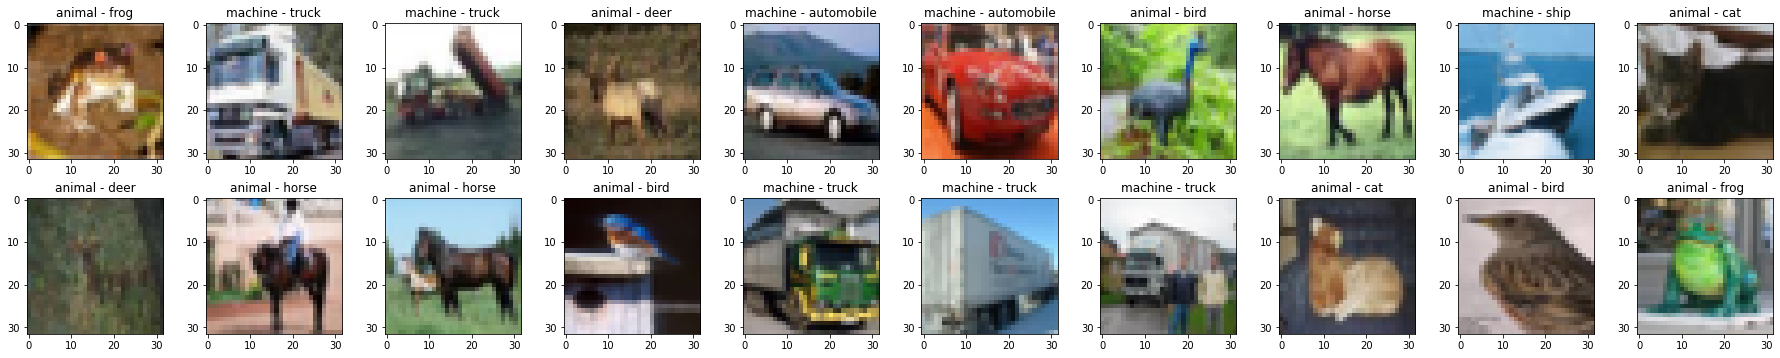

In [7]:
(x_train, y_super_train, y_sub_train), (x_test, y_super_test, y_sub_test) = get_cifar10()
plot_sample_images((x_train, y_super_train, y_sub_train), v_get_labels)

In [8]:
def gen_hierarchy(super_label, sub_label, use_argmax = False):
    combined_labels = np.stack((np.argmax(super_label, axis = 1), np.argmax(sub_label, axis = 1)), axis = 1)
    unique_combinations = np.unique(combined_labels, axis = 0)
    hierarchy={}
    for combination in unique_combinations:
        super_class, sub_class = combination
        if super_class in hierarchy.keys():
            hierarchy[super_class].append(sub_class)
        else:
            hierarchy[super_class] = [sub_class]
    return hierarchy

In [9]:
def conv_block(units, kernel_size = (3,3), stride=(1, 1), dropout=0.2, activation='relu', block=1, layer=1, class_type='default'):

    def layer_wrapper(inp):
        x = Conv2D(units, kernel_size, padding='same', name=f'{class_type}_block{block}_conv{layer}')(inp)
        x = Activation(activation, name=f'{class_type}_block{block}_act{layer}')(x)
        x = Dropout(dropout, name=f'{class_type}_block{block}_dropout{layer}')(x)
        x = BatchNormalization(name=f'{class_type}_block{block}_bn{layer}')(x)
        return x
    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='default_fc1'):
    def layer_wrapper(inp):
        x = Dense(units, name=name)(inp)
#         x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x
    return layer_wrapper



def create_base_layer(img_input, conv_dropout=0.1, fc_dropout=0.3, activation='relu', class_type = 'default', nodes = 64):
    
    # Block 1
    block = 1
    x = conv_block(nodes, kernel_size = (5, 5),dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(img_input)
    x = conv_block(nodes, kernel_size = (5, 5),dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name=f'{class_type}_block{block}_pool')(x)
    
    # Block 2
    block += 1
    x = conv_block(nodes * 2, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(x)
    x = conv_block(nodes * 2, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name=f'{class_type}_block{block}_pool')(x)

    # Block 3
    block += 1
    x = conv_block(nodes * 4, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(x)
    x = conv_block(nodes * 4, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name=f'{class_type}_block{block}_pool')(x)

    # Block 4
    block += 1
    x = conv_block(nodes * 8, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(x)
    x = conv_block(nodes * 8, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name=f'{class_type}_block{block}_pool')(x)

    x = GlobalAveragePooling2D()(x)
    
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(x)
    
    return x


def create_layer(img_input, n_classes, conv_dropout=0.1, fc_dropout=0.3, activation='relu', class_type = 'default', embedding = None, nodes = 64):
    x = dense_block(nodes * 4, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2')(img_input)
#     x = dense_block(nodes * 4, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc3')(x)
    if embedding is not None:
        x = tf.keras.layers.Concatenate()([x, embedding])
    output = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    return output, x

In [10]:
n_superclasses = 2
n_subclasses = 10
input_shape = x_train[0].shape

img_input = Input(shape=input_shape, name='input')

base_layer = create_base_layer(img_input,class_type = 'base')

nodes = 64
class_type = 'super'
super_layer_embedding = dense_block(nodes * 4, name=f'{class_type}_fc2')(base_layer)
super_layer_final = Dense(n_superclasses, name=f'{class_type}_final')(super_layer_embedding)
super_layer = Activation('softmax', name=f'{class_type}_output')(super_layer_final)

class_type = 'sub'
sub_layer_embedding = dense_block(nodes * 4, name=f'{class_type}_fc2')(base_layer)
sub_layer_embedding = tf.keras.layers.Concatenate()([sub_layer_embedding, super_layer_embedding])
sub_layer_final = Dense(n_subclasses, name=f'{class_type}_final')(sub_layer_embedding)
sub_layer = Activation('softmax', name=f'{class_type}_output')(sub_layer_final)

class_type = 'combination'
combination_layer = tf.keras.layers.Concatenate()([super_layer_final, sub_layer_final])
combination_layer = Dense(n_subclasses, activation='softmax', name=f'{class_type}_output')(combination_layer)


model = keras.Model(inputs=img_input,
             outputs = [super_layer, sub_layer, combination_layer],
             name="cifar10")

In [11]:
model.summary()

Model: "cifar10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
base_block1_conv1 (Conv2D)      (None, 32, 32, 64)   4864        input[0][0]                      
__________________________________________________________________________________________________
base_block1_act1 (Activation)   (None, 32, 32, 64)   0           base_block1_conv1[0][0]          
__________________________________________________________________________________________________
base_block1_dropout1 (Dropout)  (None, 32, 32, 64)   0           base_block1_act1[0][0]           
____________________________________________________________________________________________

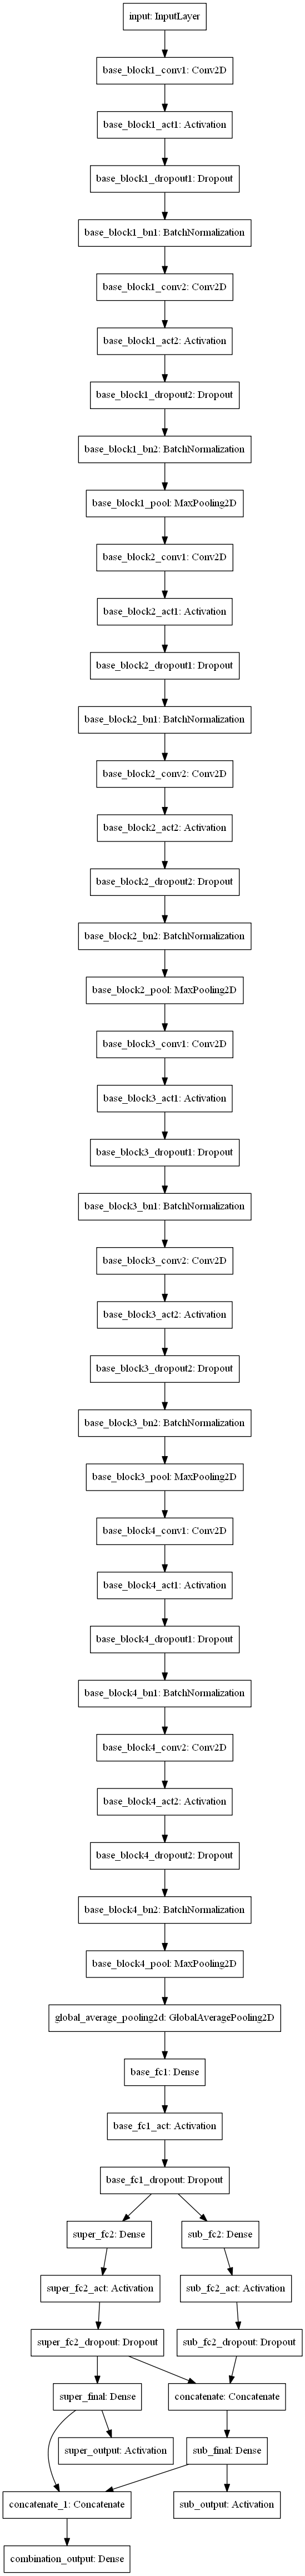

In [12]:
tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False)

In [13]:
init_lr = 1e-4
epochs = 100
# super_weight_ratio = 0.3


opt = keras.optimizers.Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(
    optimizer=opt,
    loss={
        'super_output':'categorical_crossentropy',
        'sub_output':'categorical_crossentropy',
        'combination_output': 'categorical_crossentropy',
    },
    metrics={
        'super_output':'accuracy',
        'sub_output':'accuracy',
        'combination_output':'accuracy',
    }, 
    loss_weights=[0.35, 0.5, 0.15]
)

In [14]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = keras.callbacks.TensorBoard(
#     log_dir=logdir,
#     histogram_freq=1
# )

earlystop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-5,
    patience=15
)

# checkpoint_callbacks = [
#     keras.callbacks.ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]

history = model.fit(
    x_train, 
    y={"super_output": y_super_train, "sub_output": y_sub_train, "combination_output":y_sub_train},
    validation_data=(x_test,{"super_output": y_super_test, "sub_output": y_sub_test, "combination_output": y_sub_test}),
    batch_size = 512,
    epochs=epochs,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[
#         tensorboard_callback,
        earlystop_callback
    ]
)

Epoch 1/100
79/79 [==============================] - 20s 146ms/step - loss: 1.6386 - super_output_loss: 0.4828 - sub_output_loss: 2.1830 - combination_output_loss: 2.5208 - super_output_accuracy: 0.7694 - sub_output_accuracy: 0.2388 - combination_output_accuracy: 0.1475 - val_loss: 1.8769 - val_super_output_loss: 0.6872 - val_sub_output_loss: 2.5510 - val_combination_output_loss: 2.4061 - val_super_output_accuracy: 0.5947 - val_sub_output_accuracy: 0.0997 - val_combination_output_accuracy: 0.0997
Epoch 2/100
79/79 [==============================] - 9s 114ms/step - loss: 1.2117 - super_output_loss: 0.2817 - sub_output_loss: 1.6159 - combination_output_loss: 2.0347 - super_output_accuracy: 0.8887 - sub_output_accuracy: 0.4180 - combination_output_accuracy: 0.2537 - val_loss: 2.2758 - val_super_output_loss: 0.7862 - val_sub_output_loss: 3.2056 - val_combination_output_loss: 2.6521 - val_super_output_accuracy: 0.5947 - val_sub_output_accuracy: 0.0997 - val_combination_output_accuracy: 0.09

In [16]:
yhat_super_test, yhat_sub_test, _= model.predict(x_test, use_multiprocessing=True)

In [17]:
y_super, yhat_super = v_get_labels(np.argmax(y_super_test, axis=1), 'super'), v_get_labels(np.argmax(yhat_super_test, axis=1), 'super')
y_sub, yhat_sub = v_get_labels(np.argmax(y_sub_test, axis=1),'sub'), v_get_labels(np.argmax(yhat_sub_test, axis=1),'sub')

In [18]:
pd.crosstab(y_super, yhat_super, rownames=['Actual'], colnames=['Pred'])

Pred,animal,machine
Actual,,
animal,5736,264
machine,175,3825


In [19]:
pd.crosstab(y_sub, yhat_sub, rownames=['Actual'], colnames=['Pred'])

Pred,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Actual,,,,,,,,,,
airplane,891,8,7,8,11,5,6,11,46,7
automobile,38,833,3,11,5,4,5,5,30,66
bird,112,0,547,86,78,89,52,26,9,1
cat,38,1,19,613,41,223,37,18,5,5
deer,29,1,36,79,727,51,32,38,7,0
dog,22,1,15,145,30,748,8,29,1,1
frog,17,1,13,71,25,55,813,2,2,1
horse,22,1,6,36,56,59,2,814,0,4
ship,68,16,6,10,6,11,5,0,870,8


In [20]:
def calculate_hiearchy_mismatch(super_labels, sub_labels, hierarchy):
    mismatch = 0
    assert len(super_labels) == len(sub_labels)
    for idx, super_label in enumerate(super_labels):
        if sub_labels[idx] not in hierarchy[super_label]:
            mismatch += 1
    return mismatch

In [21]:
n_rows = len(x_test)
error_rate_super = sum(y_super != yhat_super) / n_rows
error_rate_sub = sum(y_sub != yhat_sub) / n_rows

hierarchy = gen_hierarchy(y_super_train, y_sub_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_super_test, axis=1), np.argmax(yhat_sub_test, axis=1), hierarchy)
mismatch_rate = n_mismatch / n_rows

print(f"Super Class Error Rate: {error_rate_super}\nSub Class Error Rate: {error_rate_sub}\nMismatch Rate: {mismatch_rate}")

Super Class Error Rate: 0.0439
Sub Class Error Rate: 0.2328
Mismatch Rate: 0.01
